# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
****

In [38]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('cms_hospital_readmissions.csv')

****
## Preliminary Analysis

In [3]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


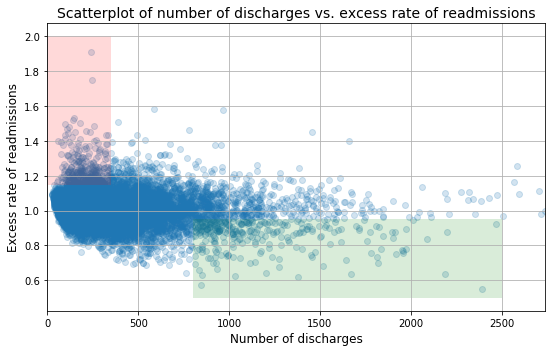

In [4]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
### Exercise

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.

****

## Answers:

* **The analysis above hasn't been verified with statistically significant methods. And in order to draw conclusions at such a large scale based on a the sample, we need to perform statistical tests using test statistics and p-value to be sure of whether our conclusins make sense statistically. The preliminary analysis is correct but it's not enough to draw conclusions and provide recommendations.**

>Asking the following questions and statistically answering them would be more insightful:
1. Is the true population mean for excess readmission rate in hospitals with <100 discharges = 1.023?
2. Is the true population mean for excess readmission rate in hospitals with >1000 discharges = 0.987?
3. Is there a statitically significant difference between the mean excess readmission rates of hospitals with <100 discharges vs those with >1000 discharges?

* **Answering these questions would help us draw more meaningful conclusions from the data nd provide better recommendation.**

In [8]:
less_than_100 = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges']<100]
greater_than_1000 = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges']>1000]

In [14]:
#Cleaning up the rows where Excess Readmission Ratio is not provided/null
less_than_100=less_than_100[less_than_100['Excess Readmission Ratio'].notnull()]
greater_than_1000=greater_than_1000[greater_than_1000['Excess Readmission Ratio'].notnull()]

In [16]:
ERR_100 = np.array(less_than_100['Excess Readmission Ratio'])
ERR_1000= np.array(greater_than_1000['Excess Readmission Ratio'])

* **Checking whether in hospitals/facilities with number of discharges < 100, ture population mean excess readmission rate is 1.023.**
> Ho (Null Hypothesis) : True popuation mean ERR for hospitals with <100 discharges = 1.023 <br>
Ha (Alternate Hypothesis) : True popuation mean ERR for hospitals with <100 discharges != 1.023

<br>
We will perform bootstrap analysis for the hypothesis testing.

In [19]:
shifted_ERR_100=ERR_100-np.mean(ERR_100)+1.023

In [20]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))


def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [21]:
def difference_from_original(data, original=1.023):
    return (np.mean(data)-original)

diff_observed=difference_from_original(ERR_100)

In [22]:
bs_reps = draw_bs_reps(shifted_ERR_100, difference_from_original, 100000)
p_val=np.sum(bs_reps<=diff_observed) /len(bs_reps)

alpha=0.01
print('Null Hypothesis : True popuation mean ERR for hospitals with <100 discharges = 1.023 \np-value = ', p_val)
if p_val < alpha:  
    print("Verdict: The null hypothesis can be rejected based on bootstrapping analysis")
else:
    print("Verdict: The null hypothesis cannot be rejected based on bootstrapping analysis")

Null Hypothesis : True popuation mean ERR for hospitals with <100 discharges = 1.023 
p-value =  0.4129
Verdict: The null hypothesis cannot be rejected based on bootstrapping analysis


* **Checking whether in hospitals/facilities with number of discharges > 1000, ture population mean excess readmission rate is 0.978.**
> Ho (Null Hypothesis) : True popuation mean ERR for hospitals with >1000 discharges = 0.987 <br>
Ha (Alternate Hypothesis) : True popuation mean ERR for hospitals with >1000 discharges != 0.987

<br>
We will perform bootstrap analysis for the hypothesis testing.

In [23]:
shifted_ERR_1000=ERR_1000-np.mean(ERR_1000)+0.978

In [24]:
diff_observed=difference_from_original(ERR_1000)

In [34]:
bs_reps = draw_bs_reps(shifted_ERR_1000, difference_from_original, 1000)
p_val=np.sum(bs_reps<=diff_observed) /len(bs_reps)

alpha=0.01
print('Null Hypothesis : True popuation mean ERR for hospitals with >1000 discharges = 0.987 \np-value = ', p_val)
if p_val < alpha:  
    print("Verdict: The null hypothesis can be rejected based on bootstrapping analysis")
else:
    print("Verdict: The null hypothesis cannot be rejected based on bootstrapping analysis")

Null Hypothesis : True popuation mean ERR for hospitals with >1000 discharges = 0.987 
p-value =  0.512
Verdict: The null hypothesis cannot be rejected based on bootstrapping analysis


**Based on the above analysis, we verified that the provided means were true population means and we can proceed with comparing the two population samples.
*****

### * Now we will perform a 2 sample t, one tailed test to compare the ERR means of the two populations and compute whether the two are significantly different from each other

> Ho (Null Hypothesis) : mean ERR for hospitals with <100 discharges = mean ERR for hospitals with >1000 discharges <br>
Ha (Alternate Hypothesis) : mean ERR for hospitals with <100 discharges > mean ERR for hospitals with >1000 discharges

In [27]:
ERR_100_mean = np.mean(ERR_100)
ERR_100_std = np.std(ERR_100)
ERR_100_n = len(ERR_100)

ERR_1000_mean = np.mean(ERR_1000)
ERR_1000_std = np.std(ERR_1000)
ERR_1000_n = len(ERR_1000)

In [32]:
diff_of_mean = ERR_100_mean - ERR_1000_mean
std_100_1000 = (ERR_100_std**2 / ERR_100_n) + (ERR_1000_std**2 / ERR_1000_n)
t=diff_of_mean/np.sqrt(std_100_1000)

print('value of t-statistic = ',t)

value of t-statistic =  7.6095459123357525


In [36]:
p=stats.t.sf(np.abs(t), ERR_1000_n-1) 

print('Null Hypothesis : mean ERR for hospitals with <100 discharges = mean ERR for hospitals with >1000 discharges  \np-value = ', p)
if p < alpha:  
    print("Verdict: The null hypothesis can be rejected based on bootstrapping analysis")
else:
    print("Verdict: The null hypothesis cannot be rejected based on bootstrapping analysis")
    

Null Hypothesis : mean ERR for hospitals with <100 discharges = mean ERR for hospitals with >1000 discharges  
p-value =  7.791162106429416e-14
Verdict: The null hypothesis can be rejected based on bootstrapping analysis


**We got a p-value is quite small. This means that there is very small chance of getting the results assuming the null hypothesis is true. So, we have enough evidence to suggest that the mean excess readmission ratio for smaller hospitals (<100 discharges) greater than the mean excess readmission ratio for larger hospitals (>1000 discharges).**

In [42]:
# Calculating the confidence interval for difference in means
cm = sms.CompareMeans(sms.DescrStatsW(ERR_100), sms.DescrStatsW(ERR_1000))
print ('The cofidence interval for difference in means of the two populations is : ',cm.tconfint_diff(usevar='unequal'))


The cofidence interval for difference in means of the two populations is :  (0.03284015468773753, 0.05572570331634981)


* **After perfoming the statistical tests above, we can conclude the following:**
> 1. There is significant difference between the means excess readmission rates in smaller and bigger hospitals/facilites.
> 2. Smaller hospitals with <100 discharges have a hight excess readmission rate as compared to larger hospitals with >1000 discharges.
> 3. These could be suggestive that the smaller hospitals do not have enough facilities or expertise to treat patients and thus larger proportion of patients end up readmitting.

* **Smaller hospitals need to be surveyed for other underlying features which could be causing the higher readmission ratio and be urged to fix the issued to improve their readmission ratio or face reduced payments. <br> Optionally, larger hospitals could team-up with smaller ones if they are in geographical vicinity and share expertise as well as facilities if required**

****
### The plot above gives a visualization of how the number of discharge and excess readmission ratios are correlated with each other and how they differ as the numbr of discharges increase.
We can create a few other plots to only compare the two populations with each other and visually figure out how they are different in addition to the above statistical testing.

Text(0.5,1,'Scatter plot of Number of discharge vs Excess Readmission ratio for two extremes of population')

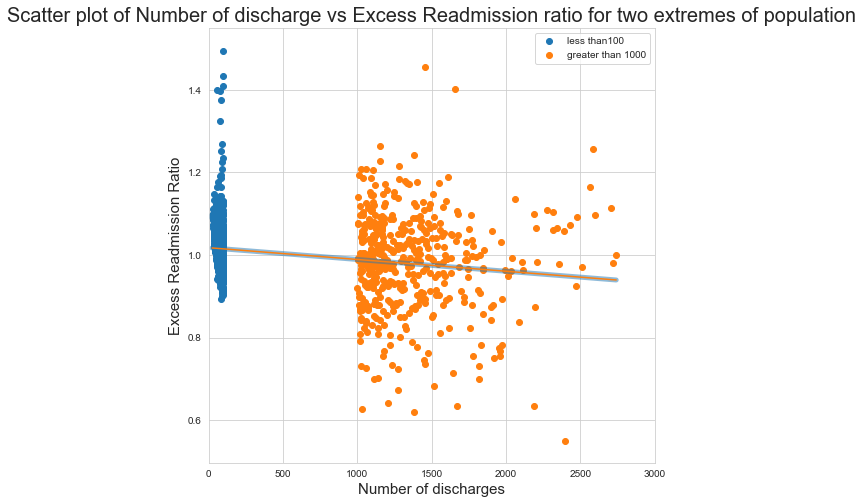

In [65]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,8))
plt.scatter('Number of Discharges', 'Excess Readmission Ratio', data=less_than_100, label='less than100')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), linewidth=5,alpha=0.5)

plt.scatter('Number of Discharges', 'Excess Readmission Ratio', data=greater_than_1000, label='greater than 1000')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

plt.xlim(1,3000)
plt.xlabel('Number of discharges', fontsize=15)
plt.ylabel('Excess Readmission Ratio',fontsize=15)
plt.legend(loc='upper right')
plt.title('Scatter plot of Number of discharge vs Excess Readmission ratio for two extremes of population', fontsize=20)


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Distribution of Excess Readmission Ratios for the two samples')

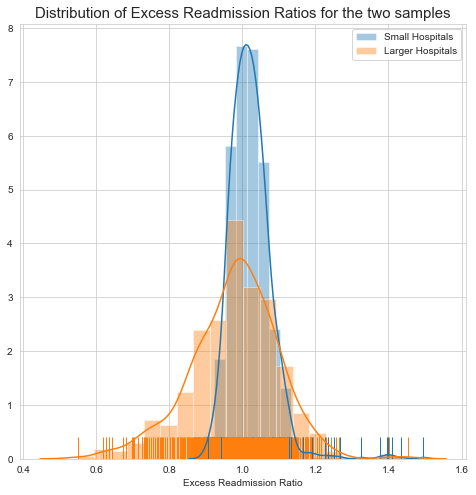

In [77]:
plt.figure(figsize=(8,8))

sns.distplot(less_than_100['Excess Readmission Ratio'], bins=20, rug=True, label='Small Hospitals')
sns.distplot(greater_than_1000['Excess Readmission Ratio'], bins=20, rug=True, label='Larger Hospitals')
plt.legend(loc='upper right')
plt.title('Distribution of Excess Readmission Ratios for the two samples',fontsize=15)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 576x576 with 0 Axes>

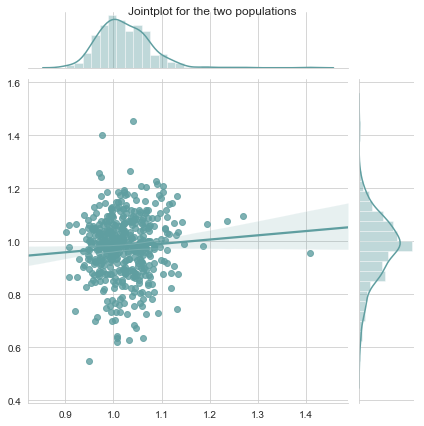

In [76]:
_=plt.figure(figsize=(8,8))
_=sns.jointplot(x=np.random.choice(ERR_100, 463), y=ERR_1000, kind="reg", color="cadetblue")
_=plt.suptitle('Jointplot for the two populations', fontsize=12)